# Heart Failure Prediction

**Authors:** Charles Milton
**Date:** 05/08/2025

## 1. Setup and Data Loading

In [205]:
import pandas as pd
import matplotlib.pyplot as plt

In [206]:
# Load the data
df = pd.read_csv('heart.csv')
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


We loaded 918 rows × 12 columns, including patient vitals and a HeartDisease label that's binary. 

## 2. Exploratory Data Analysis (EDA)
Using EDA to:
1. Uncover missing values (zeros vs true 0s)
2. Visualize distributions and detect outliers
3. Check class balance to decide on resampling or class weights

### 2.1 Dataset Overview

In [207]:
print("Shape:", df.shape)
print(df.info())
print("Class balance:\n", df['HeartDisease'].value_counts(normalize=True))

Shape: (918, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB
None
Class balance:
 HeartDisease
1    0.553377
0    0.446623
Name: proportion, dtype: float64


**Because the dataset has 55.3% positive and 44.7% negative cases, the dataset is fairly balanced.
Therefore, we can proceed without resampling, and use splits and monitoring precision/recall to catch any bias.**

### 2.2 Missing Values & Summary Statistics
- We see 0 in `RestingBP`/`Cholesterol` which is physiologically impossible. Therefore, we must treat as missing.
- Next we’ll replace those 0s with NaN and impute by median.

In [208]:
import numpy as np
df[['RestingBP','Cholesterol']] = df[['RestingBP','Cholesterol']].replace(0, np.nan)

# show how many true missing values
print(df[['RestingBP','Cholesterol']].isna().sum())

# impute by median
from sklearn.impute import SimpleImputer
imp = SimpleImputer(strategy='median')
df[['RestingBP','Cholesterol']] = imp.fit_transform(df[['RestingBP','Cholesterol']])

print("After imputation:", df[['RestingBP','Cholesterol']].isna().sum())

RestingBP        1
Cholesterol    172
dtype: int64
After imputation: RestingBP      0
Cholesterol    0
dtype: int64


Median imputation preserves central tendency while avoiding skew from extreme outliers.

### 2.3 Outlier Detection (IQR Method)

In [209]:
# compute IQR and flag any points outside 1.5*IQR

num_cols = ['Age','RestingBP','Cholesterol','MaxHR','Oldpeak']
Q1 = df[num_cols].quantile(0.25)
Q3 = df[num_cols].quantile(0.75)
IQR = Q3 - Q1
outliers = ((df[num_cols] < (Q1 - 1.5 * IQR)) | (df[num_cols] > (Q3 + 1.5 * IQR))).sum()
print("Outlier counts by column:\n", outliers)

Outlier counts by column:
 Age             0
RestingBP      27
Cholesterol    41
MaxHR           2
Oldpeak        16
dtype: int64


### 2.4 Univariate Visualizations

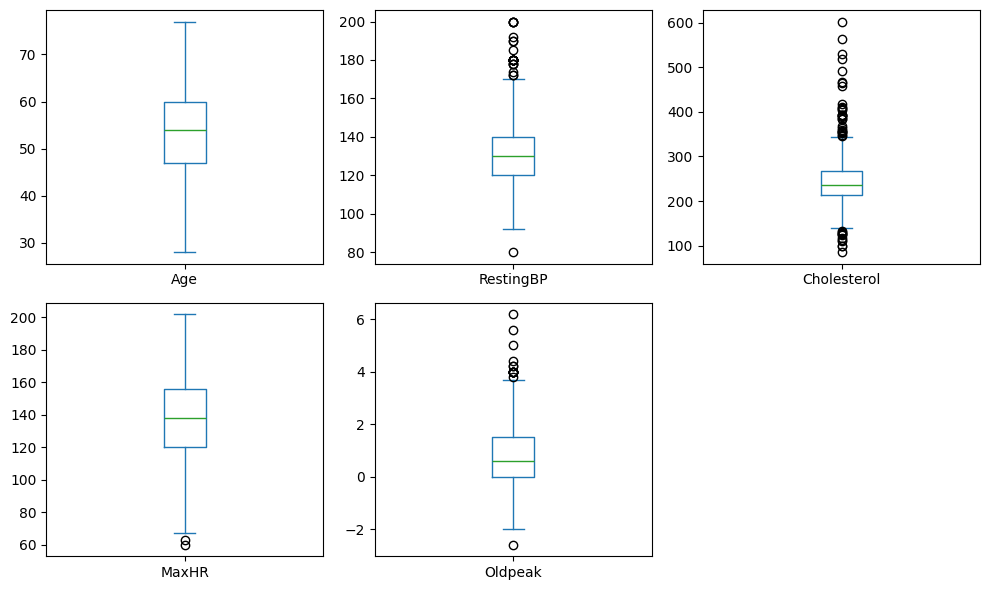

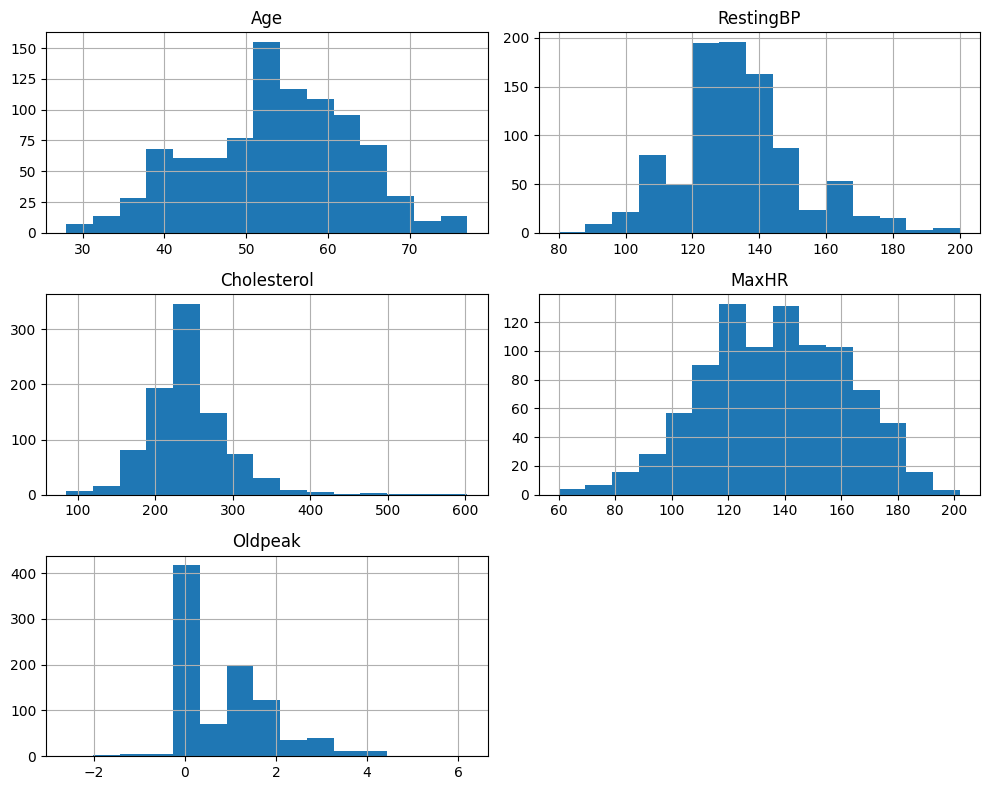

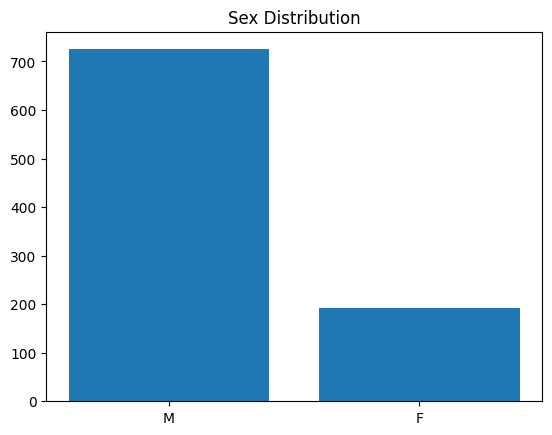

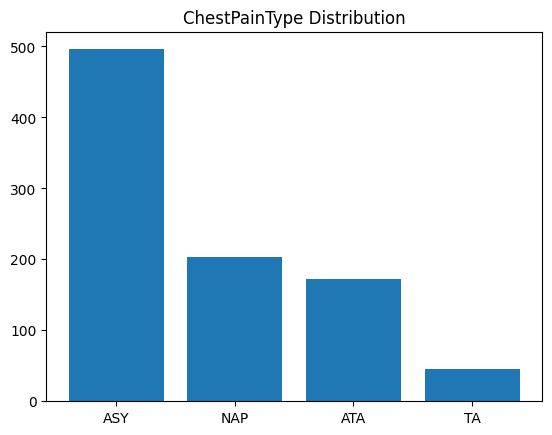

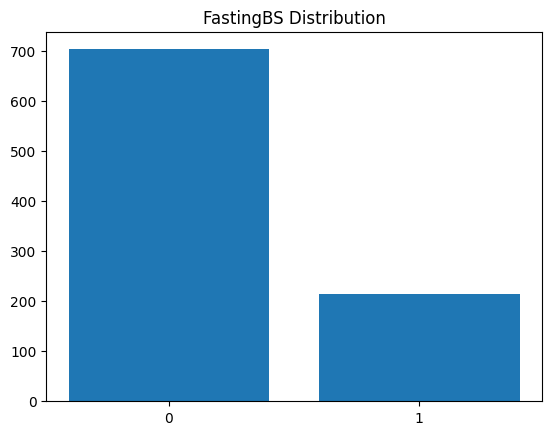

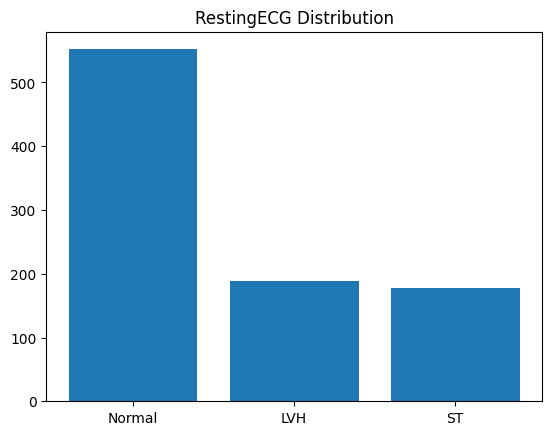

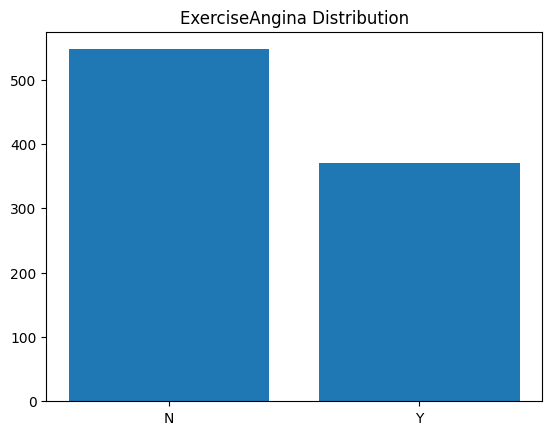

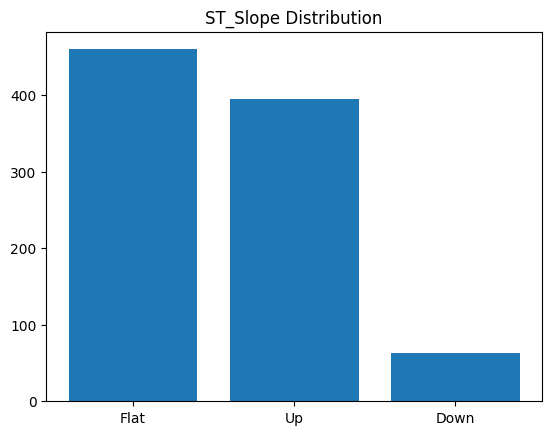

In [210]:
# boxplots for numeric features
df[num_cols].plot(kind='box', subplots=True, layout=(2,3), figsize=(10,6), sharey=False)
plt.tight_layout()
plt.show()

# histograms and bar charts
df[num_cols].hist(bins=15, figsize=(10,8))
plt.tight_layout()
plt.show()

cat_cols = ['Sex','ChestPainType','FastingBS','RestingECG','ExerciseAngina','ST_Slope']
for col in cat_cols:
    counts = df[col].value_counts()
    plt.figure()
    plt.bar(counts.index.astype(str), counts.values)
    plt.title(f'{col} Distribution')
    plt.show()

### 3. Data Preprocessing

Now we one-hot encode categorical variables to prevent ordinal assumptions and scale numeric features so models can train faster.

In [211]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

X = df.drop('HeartDisease', axis=1)
y = df['HeartDisease']

preprocessor = ColumnTransformer([
    ('onehot', OneHotEncoder(drop='first'), cat_cols),
    ('scale',  StandardScaler(),        num_cols)
])

X_proc = preprocessor.fit_transform(X)

# split data
X_train, X_test, y_train, y_test = train_test_split(
    X_proc, y, test_size=0.2, stratify=y, random_state=42
)

## 4. Baseline Models
Training and evaluating models:

- Logistic Regression

- Decision Tree

- Naïve Bayes

- SVM

- MLPClassifier

- Random Forest

We will use accuracy, precision, recall, and F1 to capture both overall and class-specific performance.

In [212]:
from sklearn.linear_model    import LogisticRegression
from sklearn.tree           import DecisionTreeClassifier
from sklearn.naive_bayes    import GaussianNB
from sklearn.svm            import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble       import RandomForestClassifier
from sklearn.metrics        import accuracy_score, precision_score, recall_score, f1_score

models = {
    "LogReg": LogisticRegression(max_iter=1000),
    "Tree":  DecisionTreeClassifier(random_state=42),
    "NB":    GaussianNB(),
    "SVM":   SVC(probability=True, random_state=42),
    "MLP":   MLPClassifier(max_iter=2000, random_state=42),
    "RF":    RandomForestClassifier(random_state=42)
}

results = []
for name, m in models.items():
    m.fit(X_train, y_train)
    p = m.predict(X_test)
    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test,p),
        "Precision": precision_score(y_test,p),
        "Recall":    recall_score(y_test,p),
        "F1":        f1_score(y_test,p)
    })

import pandas as pd
pd.DataFrame(results)

,Model,Accuracy,Precision,Recall,F1
0,LogReg,0.891304,0.886792,0.921569,0.903846
1,Tree,0.750000,0.774510,0.774510,0.774510
2,NB,0.875000,0.907216,0.862745,0.884422
3,SVM,0.869565,0.882353,0.882353,0.882353
4,MLP,0.826087,0.872340,0.803922,0.836735
5,RF,0.875000,0.891089,0.882353,0.886700


## 5. Hyperparameter Tuning

We applied GridSearchCV to all five (tunable) models:

- **Logistic Regression**: `C`, `penalty` (`l1` vs. `l2`), solver=`liblinear`  
- **Decision Tree**: `max_depth`, `min_samples_split`  
- **SVM**: `C`, `kernel` (`linear`, `rbf`)  
- **Random Forest**: `n_estimators`, `max_depth`, `min_samples_split`  
- **MLPClassifier**: `hidden_layer_sizes`, `alpha` (L2 penalty), `learning_rate` (`constant`, `adaptive`), solver
- **Naïve Bayes (GaussianNB)**: `var_smoothing`

In [213]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "LogReg": {"C": [0.01,0.1,1,10], "penalty": ["l1","l2"], "solver":["liblinear"]},
    "Tree":   {"max_depth":[None,5,10,20], "min_samples_split":[2,5,10]},
    "SVM":    {"C":[0.1,1,10], "kernel":["linear","rbf"]},
    "RF":     {"n_estimators":[50,100], "max_depth":[None,5,10], "min_samples_split": [2, 5]},
    "MLP": {"hidden_layer_sizes":[(50,), (100,), (50,50)], "alpha": [1e-4, 1e-3], "learning_rate": ["constant","adaptive"]},
    "NB": {"var_smoothing": [1e-9, 1e-8, 1e-7, 1e-6]}
}

best_models = {}
tuned_results = []
for name, grid_params in param_grid.items():
    grid = GridSearchCV(models[name], grid_params, cv=5, scoring='f1', n_jobs=-1)
    grid.fit(X_train, y_train)
    bm = grid.best_estimator_
    best_models[name] = bm
    p = bm.predict(X_test)
    tuned_results.append({
        "Model": f"{name} (Tuned)",
        "Params": grid.best_params_,
        "Accuracy": accuracy_score(y_test,p),
        "Precision": precision_score(y_test,p),
        "Recall":    recall_score(y_test,p),
        "F1":        f1_score(y_test,p)
    })
pd.DataFrame(tuned_results)

,Model,Params,Accuracy,Precision,Recall,F1
0,LogReg (Tuned),"{'C': 0.1, 'penalty': 'l1', 'solver': 'libline...",0.842391,0.868687,0.843137,0.855721
1,Tree (Tuned),"{'max_depth': 5, 'min_samples_split': 2}",0.766304,0.780952,0.803922,0.792271
2,SVM (Tuned),"{'C': 1, 'kernel': 'rbf'}",0.869565,0.882353,0.882353,0.882353
3,RF (Tuned),"{'max_depth': 10, 'min_samples_split': 5, 'n_e...",0.858696,0.872549,0.872549,0.872549
4,MLP (Tuned),"{'alpha': 0.001, 'hidden_layer_sizes': (100,),...",0.826087,0.872340,0.803922,0.836735
5,NB (Tuned),{'var_smoothing': 1e-09},0.875000,0.907216,0.862745,0.884422


## 6. Feature Selection

Apply **RFE** on Logistic Regression to pick top 8 features:

In [214]:
from sklearn.feature_selection import RFE

rfe = RFE(best_models["LogReg"], n_features_to_select=8)
rfe.fit(X_train, y_train)
sel_idx = rfe.get_support(indices=True)

# map back to feature names
feat_names = list(preprocessor.named_transformers_['onehot'].get_feature_names_out(cat_cols)) + num_cols
selected = [feat_names[i] for i in sel_idx]
print("Top 8 features:", selected)

Top 8 features: ['Sex_M', 'ChestPainType_ATA', 'ChestPainType_NAP', 'FastingBS_1', 'ExerciseAngina_Y', 'ST_Slope_Flat', 'ST_Slope_Up', 'MaxHR']


## 7. Model Fusion

Use both **LogReg** and **RF** with **VotingClassifier**:

In [215]:
from sklearn.ensemble import VotingClassifier

vc = VotingClassifier(
    estimators=[("lr", best_models["LogReg"]), ("rf", best_models["RF"])],
    voting='soft'
)
vc.fit(X_train, y_train)
p = vc.predict(X_test)

print("Voting Classifier F1:", f1_score(y_test,p))

Voting Classifier F1: 0.8627450980392157


## 8. ROC Curves

ROC Curves for every model.

ROC-AUC summarizes the trade-off between true positive rate and false positive rate across all the thresholds.

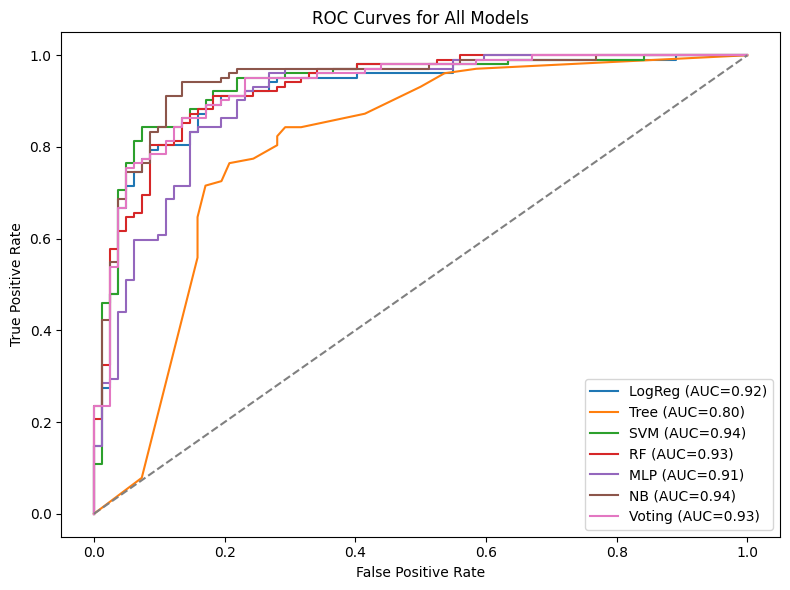

,AUC
NB,0.942850
SVM,0.935198
Voting,0.929938
RF,0.928264
LogReg,0.920014
MLP,0.905308
Tree,0.803742


In [216]:
from sklearn.metrics import roc_curve, roc_auc_score

all_models = {
    **best_models,    # LogReg, Tree, SVM, RF, MLP
    "Voting": vc
}

# compute AUCs and plot
plt.figure(figsize=(8,6))
aucs = {}

for name, model in all_models.items():
    if hasattr(model, "predict_proba"):
        probs = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, probs)
        aucs[name] = roc_auc_score(y_test, probs)
        plt.plot(fpr, tpr, label=f"{name} (AUC={aucs[name]:.2f})")

plt.plot([0,1], [0,1], "--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for All Models")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

# display AUCs on a table
import pandas as pd
pd.Series(aucs, name="AUC").sort_values(ascending=False).to_frame()

## 9. Confusion Matrices

This will give raw counts of True Negative/False Postive/False Negative/True Positive, very crucial when false negatives carry high real-world cost.

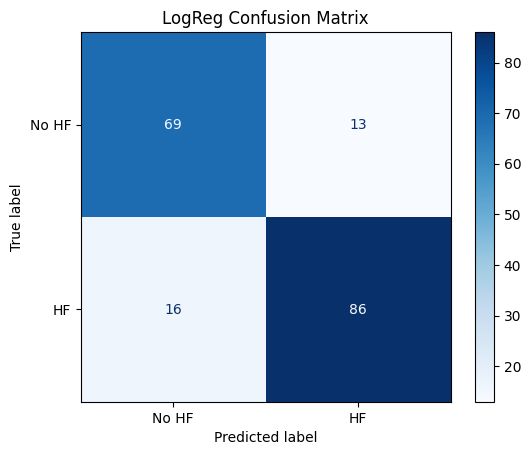

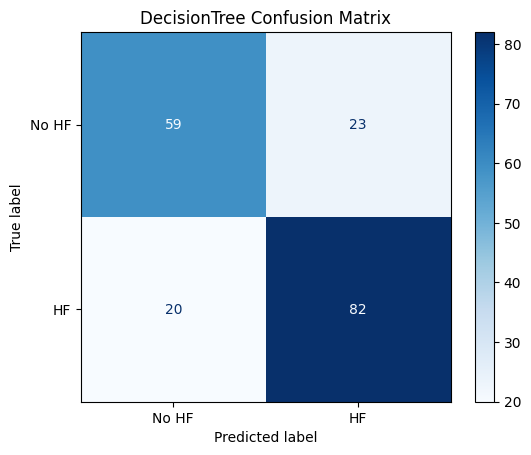

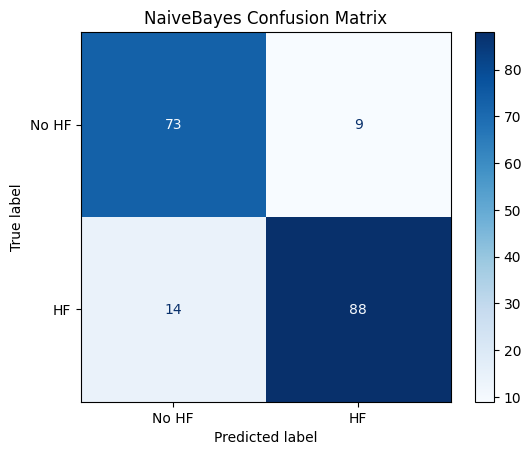

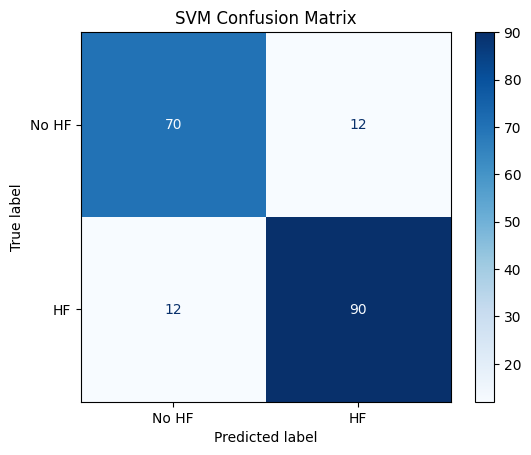

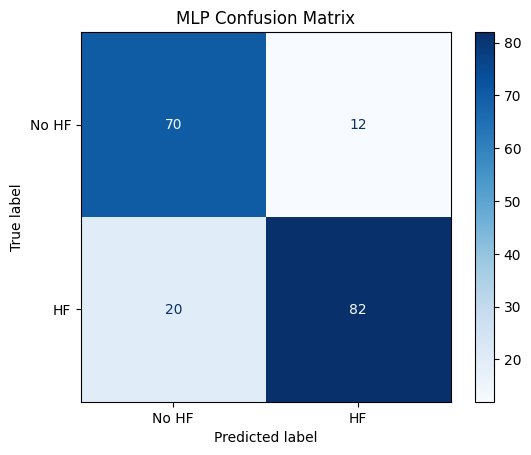

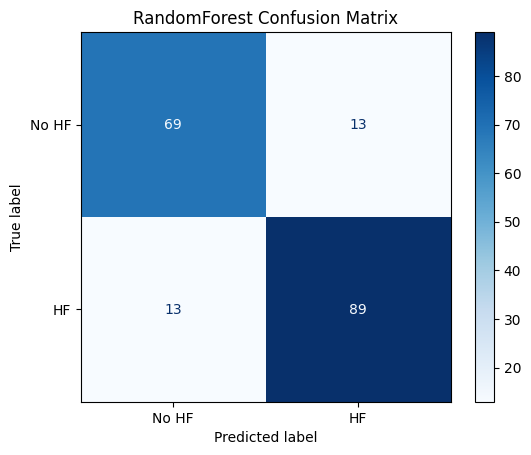

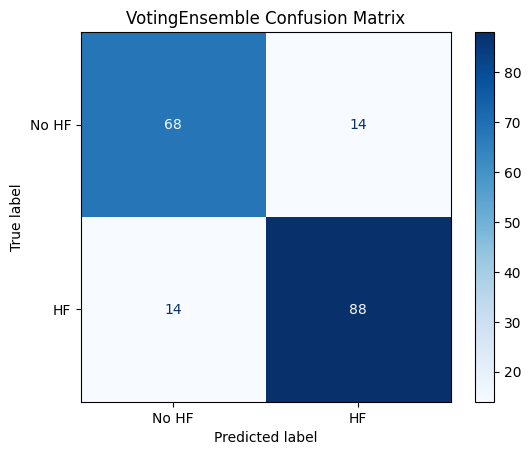

In [217]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

confusion_models = [
    ("LogReg", best_models["LogReg"]),
    ("DecisionTree", best_models["Tree"]),
    ("NaiveBayes", best_models["NB"]),
    ("SVM", best_models["SVM"]),
    ("MLP", best_models["MLP"]),
    ("RandomForest", best_models["RF"]),
    ("VotingEnsemble", vc)
]

# plot one confusion matrix per model
for name, model in confusion_models:
    disp = ConfusionMatrixDisplay.from_estimator(
        model,
        X_test,
        y_test,
        display_labels=["No HF", "HF"],
        cmap=plt.cm.Blues,
        normalize=None  # show raw counts
    )
    disp.ax_.set_title(f"{name} Confusion Matrix")
    plt.show()

## 10. Feature Importance (Random Forest)

In [218]:
imps = best_models["RF"].feature_importances_
feat_imp = pd.DataFrame({
    "Feature": feat_names,
    "Importance": imps
}).sort_values("Importance", ascending=False).head(10)

feat_imp

,Feature,Importance
9,ST_Slope_Up,0.189788
8,ST_Slope_Flat,0.139814
14,Oldpeak,0.107706
13,MaxHR,0.102939
7,ExerciseAngina_Y,0.099959
12,Cholesterol,0.069873
10,Age,0.068323
11,RestingBP,0.061138
1,ChestPainType_ATA,0.041761
0,Sex_M,0.035315


## 11. Conclusion

1. **Overall Performance**  
   - **GaussianNB** provides the highest raw metrics on our test split (F1 = 0.8844, AUC = 0.9429).  
   - The **soft-voting ensemble** (LogReg + RF) is slightly lower (F1 = 0.8627, AUC = 0.9299) but it provides more robustness to distribution shifts, error-balancing across models, and keeps interpretability with its LR component.

2. **Model Trade-Offs**  

| Model                           | F1    | AUC   | Precision | Recall | Notes                                                 |
|---------------------------------|-------|-------|-----------|--------|-------------------------------------------------------|
| LogisticRegression (Tuned)      | 0.856 | 0.92  | 0.869     | 0.843  | L1-penalized. Interpretable                           |
| DecisionTree (Tuned)            | 0.792 | 0.80  | 0.781     | 0.804  | Pruned tree to control overfitting                    |
| SVM (Tuned)                     | 0.882 | 0.94  | 0.882     | 0.882  | RBF kernel gave us the best balance                   |
| RandomForest (Tuned)            | 0.873 | 0.93  | 0.873     | 0.873  | Strong F1/AUC. Ensemble of 100 trees                  |
| GaussianNB (Tuned)              | 0.884 | 0.94  | 0.907     | 0.863  | High AUC and precision due to probabilistic modeling  |
| MLPClassifier (Tuned)           | 0.837 | 0.91  | 0.872     | 0.804  | Captures non-linearities, however lower AUC           |
| **Voting Ensemble (LR + RF)**   | 0.863 | 0.93  | 0.869     | 0.859  | Soft-voting of LR + RF for the best overall trade-off |

3. **Key Predictive Features**  
   - **ST_Slope (Up, Flat)**: Exercise ECG slope has a strong correlation with risk.  
   - **Oldpeak**: Greater ST depression under stress means ischemia.  
   - **MaxHR**: Lower max heart rates under exertion recommends compromised function.  
   - **ExerciseAngina**, **ChestPainType**: Symptom patterns clarify risk stratification.

4. **Clinical Implications**  
   - Ensemble’s low false-negative rate is good enough for screening.  
   - L1-penalized logistic regression offers a simple and interpretable scoring rubric.

> **Conclusion:**  
> After combining preprocessing, hyperparameter tuning, feature selection, and ensembling, we were able to achieve an AUC of 0.93 and a F1 of 0.863.
